# __Question Set__

A client of a marketing agency has shared an export of platform data. Answer the following questions:

1. Which campaign has the highest click-through rate?
2. Which country has the highest conversion rate?
3. During which period of the year do we observe the most conversions?
4. What percentage change in conversions is observed month over month?
5. Create an overall visual representation to show how the marketing funnel (Tactic) performs in terms of conversions.

### 0. Import the data and preparation (data cleaning and exploration) for analysis

#### 0a. Data cleaning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_excel("raw_dataset.xlsx", sheet_name="Task 1 RawData")
data.head()

Date                             CampaignID  Media Cost  Impressions  \
0 2022-01-01  FW20-Run|PO203366|FB|DE|Consideration      441.17        53964   
1 2022-01-02  FW20-Run|PO559150|FB|DE|Consideration      445.27        60733   
2 2022-01-03      FW20-Run|PO424678|FB|DE|Awareness      324.52        68995   
3 2022-01-04      FW20-Run|PO756200|FB|DE|Awareness      412.02        96521   
4 2022-01-05     FW20-Run|PO456943|FB|DE|Conversion      911.34       171899   

   Clicks  Conversions  
0     560         2364  
1     521         2325  
2      76         9128  
3     129        12071  
4     534         4040

In [2]:
data.tail()

Date                            CampaignID  Media Cost  Impressions  \
512 2023-05-28   FW20-Women|PO901403|IG|UK|Awareness      125.64        48611   
513 2023-05-29  FW20-Women|PO790990|IG|UK|Conversion      184.01        30013   
514 2023-05-30  FW20-Women|PO249804|IG|UK|Conversion      164.85        29307   
515 2023-05-31  FW20-Women|PO902182|IG|DE|Conversion      129.16        21332   
516 2023-06-01  FW20-Women|PO651961|IG|DE|Conversion      150.31        19057   

     Clicks  Conversions  
512      64        11021  
513     171          598  
514     174          983  
515     132          464  
516     134          884

In [3]:
# Exclude the last row which consists of only 1 day in June 2023 to avoid inaccurate monthly analysis due to
#   the limited sample size in this month
data=data.iloc[:-1,:]
print("Number of rows and columns: ",data.shape)

Number of rows and columns:  (516, 6)


In [4]:
data.dtypes

Date           datetime64[ns]
CampaignID             object
Media Cost            float64
Impressions             int64
Clicks                  int64
Conversions             int64
dtype: object

In [5]:
# Check if all values in `Conversions` are greater than or equal to that in each corresponding row in `Clicks`
all(data["Conversions"]>=data["Clicks"])

True

As observed all the values in column `Conversions` are greater than that in the column `Clicks`

From Meta Business's definition:
* `Clicks` is the number of times that an ad was clicked based on data received from an ad platform<sup>1</sup> 
* `Conversions` is the number of times a specific action such as purchase or add to cart was taken, as recorded by your pixel, app or offline event set<sup>2</sup>
* Conversion rate is the percentage of conversions there were out of the total number of clicks<sup>3</sup>, i.e. Conversion rate = `Conversions` / `Clicks` * 100%

Therefore, `Conversions` must be less than or equal to `Clicks`<br>
***There's a possibility that the names of these two columns (`Conversions`, `Clicks`) were mistakenly matched. Additional clarification is required to verify this.***<br><br>
For the time being, in the subsequent analysis, the names of these two columns will be swapped.

<sup>1. https://www.facebook.com/business/help/1889744637938483</sup><br>
<sup>2. https://www.facebook.com/business/help/240721419708044</sup><br>
<sup>3. https://www.facebook.com/business/help/700334730144089</sup>

In [6]:
# Swap the names of the `Clicks` and `Conversions` columns
data = data.rename(columns={'Conversions': 'Clicks', 'Clicks': 'Conversions'})

In [7]:
# Split the `CampaignID` column to derive necessary data
new_col = ["Campaign Code-Name", "PO Number", "Channel", "Country Code", "Tactic"]
data[new_col] = data["CampaignID"].str.split("|", expand=True)
data[["Campaign Code", "Campaign Name"]] = data["Campaign Code-Name"].str.split("-", expand=True)

# Drop the uncessary columns
data.drop(columns=['CampaignID','Campaign Code-Name'], inplace=True)

In [8]:
data['Week Day'] = data['Date'].dt.strftime('%A')

In [9]:
print("Number of rows and columns: ",data.shape)
print("Number of duplicated rows: ",data.duplicated().sum())
data.dtypes

Number of rows and columns:  (516, 12)
Number of duplicated rows:  0


Date             datetime64[ns]
Media Cost              float64
Impressions               int64
Conversions               int64
Clicks                    int64
PO Number                object
Channel                  object
Country Code             object
Tactic                   object
Campaign Code            object
Campaign Name            object
Week Day                 object
dtype: object

In [10]:
# Check for data integrity and other information
data_info = pd.DataFrame(data.count())
data_info.rename(columns={0:'count'})
data_info['missing_value_count'] = data.isnull().sum()
data_info['unique_count']=data.nunique()
data_info

0  missing_value_count  unique_count
Date           516                    0           516
Media Cost     516                    0           501
Impressions    516                    0           515
Conversions    516                    0           389
Clicks         516                    0           504
PO Number      516                    0           516
Channel        516                    0             2
Country Code   516                    0             2
Tactic         516                    0             3
Campaign Code  516                    0             1
Campaign Name  516                    0             2
Week Day       516                    0             7

In [11]:
# Explore the statistcs of columns with "object" data type
data.describe(include='object')

PO Number Channel Country Code      Tactic Campaign Code Campaign Name  \
count        516     516          516         516           516           516   
unique       516       2            2           3             1             2   
top     PO203366      FB           DE  Conversion          FW20           Run   
freq           1     364          258         173           516           397   

        Week Day  
count        516  
unique         7  
top     Saturday  
freq          74

In [12]:
# Explore the statistcs of columns with numeric data type
data.describe(include='number').round(2)

Media Cost  Impressions  Conversions     Clicks
count      516.00       516.00       516.00     516.00
mean       413.85    106619.05       554.72   10609.99
std        205.79     46328.72       543.73   17297.54
min          9.45      2833.00         3.00     232.00
25%        233.09     72113.00       149.00    2800.25
50%        369.22     98339.00       337.50    5126.50
75%        516.14    121393.75       782.50   10336.75
max        964.45    230918.00      2842.00  127467.00

In [13]:
# Save the cleaned dataset
data.to_csv('cleaned_Round2_TaskforGeneration.csv', index=True)

#### 0b. Data exploration

### Understand the dataset distributions with visualisations

<Axes: xlabel='Conversions', ylabel='Count'>

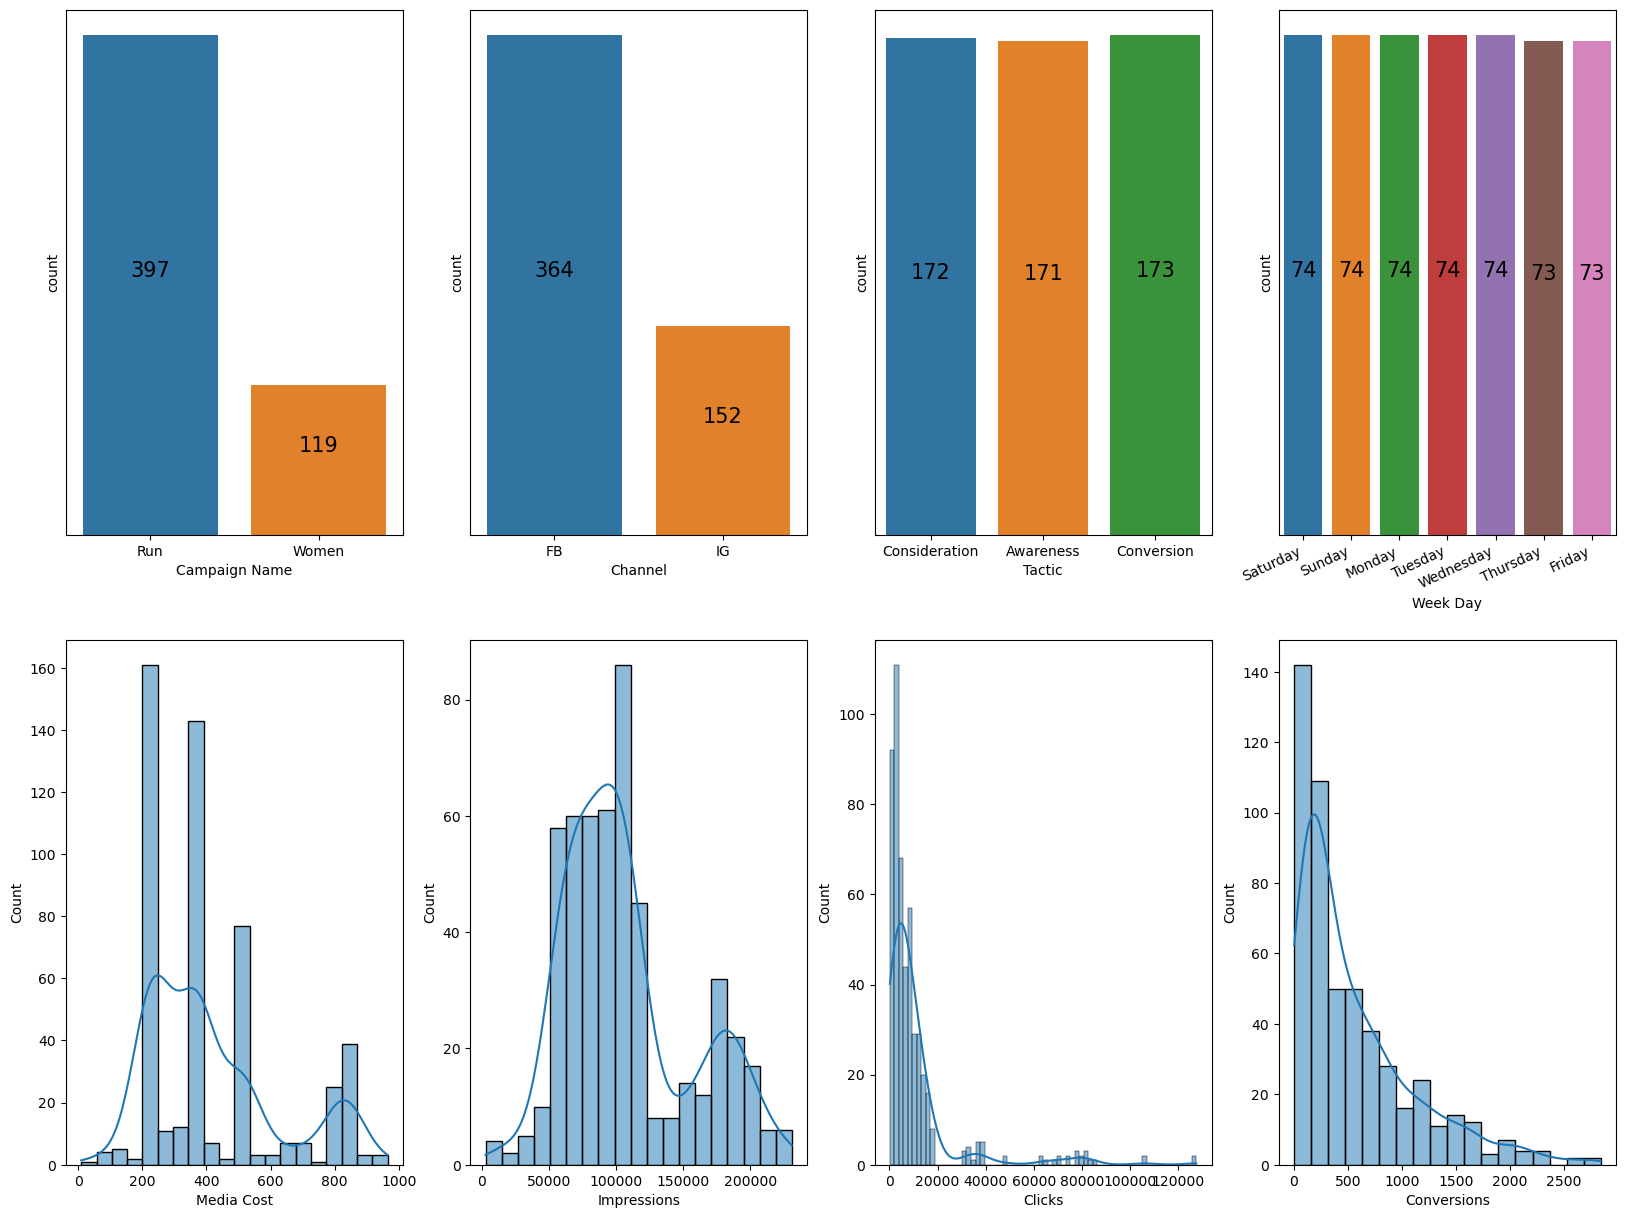

In [14]:
# Examine the distributions in different variables
fig, ax = plt.subplots(2, 4, figsize=(20, 15))

# Countplots
for i, col in enumerate(['Campaign Name', 'Channel', 'Tactic', 'Week Day']):
    countplot = sns.countplot(data, x=col, ax=ax[0, i])
    if col == 'Week Day':
        countplot.set_xticklabels(countplot.get_xticklabels(), rotation=25, ha='right')
    countplot.set_yticks([])
    for p in countplot.patches:
        countplot.annotate(int(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()/2),
                           ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=15)

# Histograms
sns.histplot(data['Media Cost'], kde=True, bins=20, ax=ax[1, 0])
sns.histplot(data['Impressions'], kde=True, ax=ax[1, 1])
sns.histplot(data['Clicks'], kde=True, ax=ax[1, 2])
sns.histplot(data['Conversions'], kde=True, ax=ax[1, 3])

* The numbers of *Run* campaign and *FB* channel are significantly great than that of *Women* campaign and *IG* channel respectively
* Both the numbers of *Media Cost* and *Impressions* show a bimodal distribution
* While both the numbers of *Clicks* and *Conversions* are highly right skewed 

<Axes: >

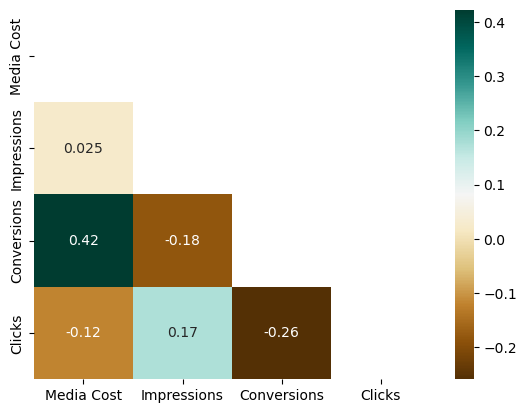

In [15]:
# Examine the correlations between different quantitative metrics
correlate = data.iloc[:,1:5].corr()
mask = np.triu(np.ones_like(correlate, dtype=bool))
sns.heatmap(correlate, annot=True, cmap='BrBG', mask=mask)

* We can see that in general there appears a positive linear correlation between the amount of `Media Cost` and the number of `Conversions`

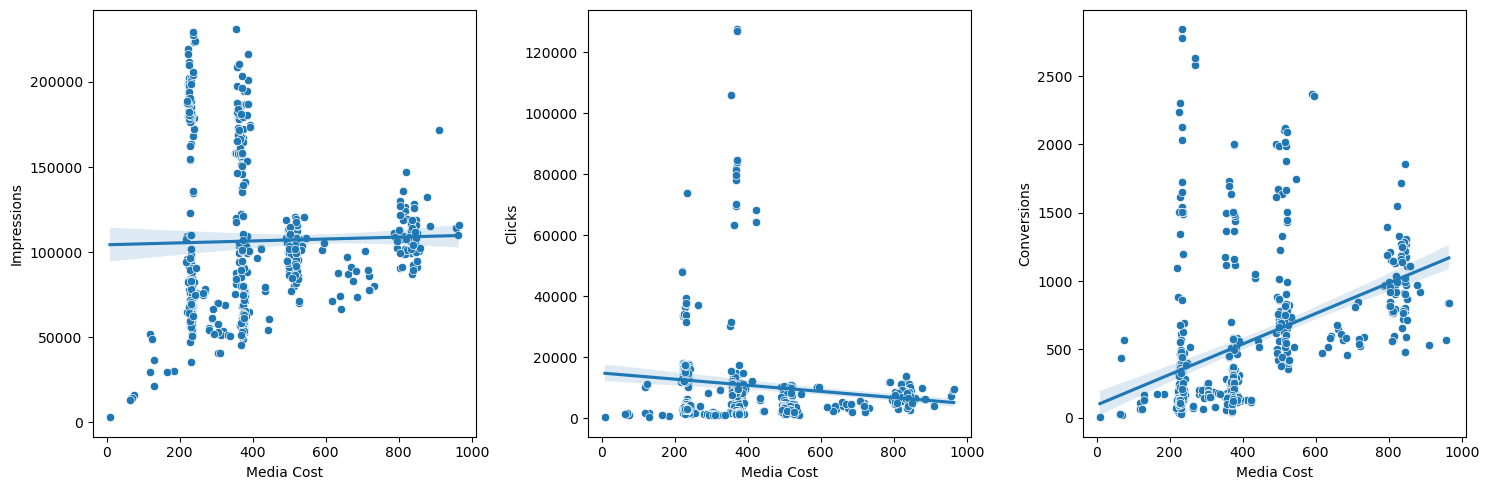

In [16]:
# Examine the correlations between number of Impressions/Clicks/Conversions and Media Cost
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first jointplot
sns.scatterplot(data=data, y="Impressions", x="Media Cost", ax=axes[0])
sns.regplot(data=data, y="Impressions", x="Media Cost", scatter=False, ax=axes[0])

# Plot the second jointplot
sns.scatterplot(data=data, y="Clicks", x="Media Cost", ax=axes[1])
sns.regplot(data=data, y="Clicks", x="Media Cost", scatter=False, ax=axes[1])

# Plot the third jointplot
sns.scatterplot(data=data, y="Conversions", x="Media Cost", ax=axes[2])
sns.regplot(data=data, y="Conversions", x="Media Cost", scatter=False, ax=axes[2])

# Display the plots
plt.tight_layout()
plt.show()

* There are correlations observed where Higher *Media Cost* associated with more number of *Impressions* and *Conversions*
* When daily *Media Cost* spending were between 200 - 400, some high values of *Impressions*. *Click*, and *Conversions* could be observed

### 1. Which campaign has the highest click-through rate? 

#### 1a. Top 5 click-through rate records

In [17]:
# Calculate the click-through rate (CTR) and the conversion rate (CVR) of each day
data["click_through_rate"] = np.divide(data["Clicks"], data["Impressions"])*100
data["conversion_rate"] = np.divide(data["Conversions"], data["Clicks"])*100
col = list(data.columns.values)
elements_to_move = ['Campaign Code', 'PO Number']
for element in elements_to_move:
    col.remove(element)
    col.append(element)
data = data[col]
data

Date  Media Cost  Impressions  Conversions  Clicks Channel  \
0   2022-01-01      441.17        53964          560    2364      FB   
1   2022-01-02      445.27        60733          521    2325      FB   
2   2022-01-03      324.52        68995           76    9128      FB   
3   2022-01-04      412.02        96521          129   12071      FB   
4   2022-01-05      911.34       171899          534    4040      FB   
..         ...         ...          ...          ...     ...     ...   
511 2023-05-27      118.82        51597           67   10285      IG   
512 2023-05-28      125.64        48611           64   11021      IG   
513 2023-05-29      184.01        30013          171     598      IG   
514 2023-05-30      164.85        29307          174     983      IG   
515 2023-05-31      129.16        21332          132     464      IG   

    Country Code         Tactic Campaign Name   Week Day  click_through_rate  \
0             DE  Consideration           Run   Saturday            4.380698   
1             DE  Consideration           Run     Sunday            3.828232   
2             DE      Awareness           Run     Monday           13.229944   
3             DE      Awareness           Run    Tuesday           12.506087   
4             DE     Conversion           Run  Wednesday            2.350217   
..           ...            ...           ...        ...                 ...   
511           UK      Awareness         Women   Saturday           19.933329   
512           UK      Awareness         Women     Sunday           22.671823   
513           UK     Conversion         Women     Monday            1.992470   
514           UK     Conversion         Women    Tuesday            3.354147   
515           DE     Conversion         Women  Wednesday            2.175136   

     conversion_rate Campaign Code PO Number  
0          23.688663          FW20  PO203366  
1          22.408602          FW20  PO559150  
2           0.832603          FW20  PO424678  
3           1.068677          FW20  PO756200  
4          13.217822          FW20  PO456943  
..               ...           ...       ...  
511         0.651434          FW20  PO191210  
512         0.580710          FW20  PO901403  
513        28.595318          FW20  PO790990  
514        17.700916          FW20  PO249804  
515        28.448276          FW20  PO902182  

[516 rows x 14 columns]

In [18]:
# Show all the campaigns in the dataset
data["Campaign Name"].unique()

array(['Run', 'Women'], dtype=object)

In [19]:
# Show the top 5 click-through rate records
data.sort_values(by="click_through_rate", ascending=False).head()

Date  Media Cost  Impressions  Conversions  Clicks Channel  \
99 2022-04-10      370.16       135515           93  126955      FB   
63 2022-03-05      369.11        85272           50   78917      FB   
98 2022-04-09      369.72       137998           90  127467      FB   
75 2022-03-17      369.19        85548           47   78067      FB   
62 2022-03-04      368.93        86526           49   78561      FB   

   Country Code     Tactic Campaign Name  Week Day  click_through_rate  \
99           DE  Awareness           Run    Sunday           93.683356   
63           DE  Awareness           Run  Saturday           92.547378   
98           DE  Awareness           Run  Saturday           92.368730   
75           DE  Awareness           Run  Thursday           91.255202   
62           DE  Awareness           Run    Friday           90.794674   

    conversion_rate Campaign Code PO Number  
99         0.073254          FW20  PO582902  
63         0.063358          FW20  PO714515  
98         0.070607          FW20  PO302782  
75         0.060205          FW20  PO203571  
62         0.062372          FW20  PO861772

* There are 2 campaigns in the dataset, *Run* and *Women* campaigns
* In terms of the daily click-through rate, *Run* had the highest value of 93.68% on 10th April 2022

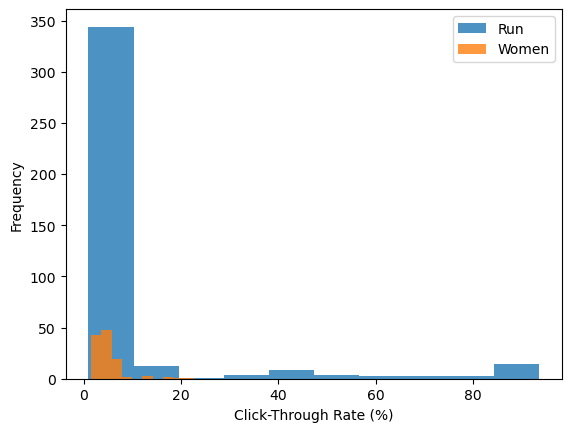

In [20]:
import importlib
importlib.reload(plt)
plt.hist(data[data['Campaign Name']=='Run']['click_through_rate'], alpha=0.8)
plt.hist(data[data['Campaign Name']=='Women']['click_through_rate'],alpha=0.8)
plt.xlabel('Click-Through Rate (%)')
plt.ylabel('Frequency')
plt.legend(['Run', 'Women'])
plt.show()

* The number of data points of *Click-through rate* in *Run* campaign is much more than that of the *Women* Campaign
* The majority of the *click-through rate* of both campaigns were concertated in lower values in between 0 - 10%

In [21]:
#  Perform a t-test to determine which of the campaigns has statistically significantly higher
#    click-through rate at 95% confidence level
from scipy.stats import ttest_ind
# Extract click-through rates for each campaign
ctr_run = data[data['Campaign Name'] == 'Run']['click_through_rate']
ctr_women = data[data['Campaign Name'] == 'Women']['click_through_rate']

# Perform t-test
t_stat, p_value = ttest_ind(ctr_run, ctr_women)

# Display the results
print(f"T-statistic: {t_stat:.3}")
print(f"P-value: {p_value:.3}")

# Check if the result is statistically significant at a 95% confidence level
alpha = 0.05
if p_value < alpha:
    if ctr_run.mean() > ctr_women.mean():
        print("The 'Run' campaign has a significantly higher click-through rate than the 'Women' campaign.")
    else:
        print("The 'Women' campaign has a significantly higher click-through rate than the 'Run' campaign.")
else:
    print("No statistically significant difference in click-through rates.")

T-statistic: 3.71
P-value: 0.000226
The 'Run' campaign has a significantly higher click-through rate than the 'Women' campaign.


#### 1b. Click-through rate by campaigns and other groups

In [22]:
# Create a function to calculate the click-through rate (CTR) and conversion rate (CVR)
def rate_cal(df, rate_type, agg_group):
    '''
    Calculate the total amount of impressions, click, and conversion,
    then display the CTR or CVR percentage corresponding to the aggregation group(s)
    and plot as bar chart
    '''
    if rate_type in ["CTR", "CVR"]:
        grouped_data = df.groupby(agg_group).agg(
        total_impressions=("Impressions", "sum"),
        total_clicks=('Clicks', 'sum'),    
        total_conversions=("Conversions", "sum"))
        
        if rate_type == "CTR":
            grouped_data["click_through_rate"] = (grouped_data["total_clicks"] / grouped_data["total_impressions"]) * 100
            display(round(grouped_data[['click_through_rate']],2))        
        elif rate_type == "CVR":
            grouped_data["conversion_rate"] = (grouped_data["total_conversions"] / grouped_data["total_clicks"]) * 100
            display(round(grouped_data[["conversion_rate"]],2))

        # Plot as bar charts
        if grouped_data.index.nlevels>1:
            grouped_data = grouped_data.iloc[:,-1].unstack(level=grouped_data.index.levels[0].name)
            bars = grouped_data.plot(kind="bar")
            plt.xticks(rotation=0)
        else:
            bars = plt.bar(grouped_data.index, grouped_data.iloc[:,-1])

        # Show the values in the bars
        for bar in bars.patches:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width() / 2, yval/2, f"{round(yval, 2)}%", ha="center", va="bottom")

        plt.yticks([])
        plt.title("Click-Through Rate") if rate_type == "CTR" else plt.title("Conversion Rate")
        plt.show()

    else:
        print("Only CTR or CVR available for calculation!")

click_through_rate
Campaign Name                    
Run                         11.21
Women                        5.30

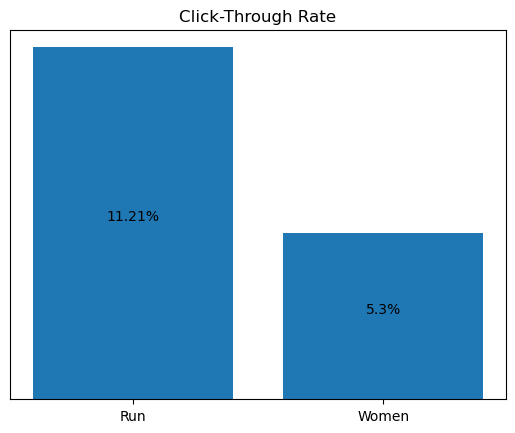

click_through_rate
Campaign Name Country Code                    
Run           DE                         12.79
              UK                          9.53
Women         DE                          4.63
              UK                          5.91

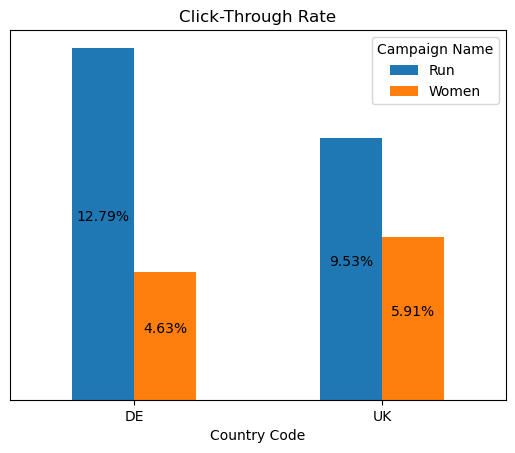

click_through_rate
Campaign Name Channel                    
Run           FB                    12.94
              IG                     5.39
Women         FB                     4.96
              IG                     5.71

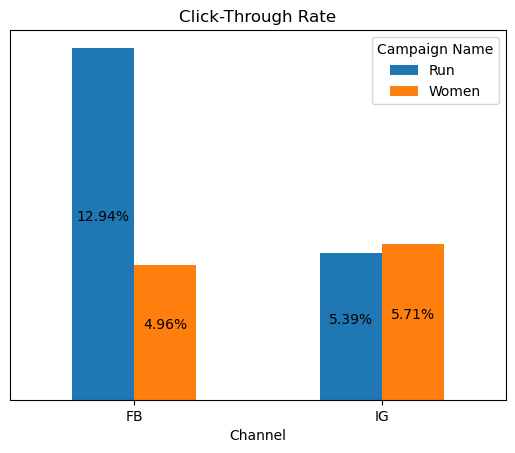

click_through_rate
Campaign Name Tactic                           
Run           Awareness                   18.44
              Consideration                4.42
              Conversion                   5.64
Women         Awareness                    6.97
              Consideration                3.64
              Conversion                   3.46

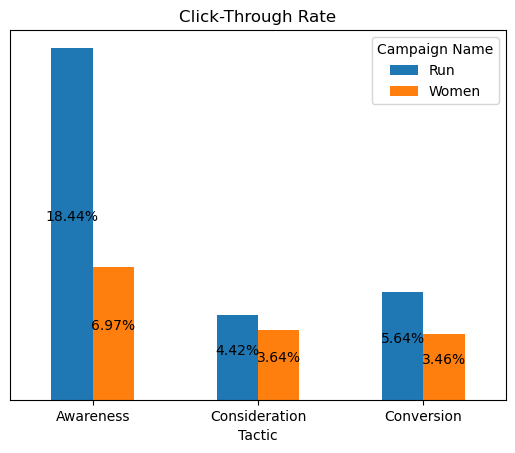

In [23]:
# Click-through rate analysis by campaigns and other metrics
rate_cal(data, "CTR", "Campaign Name")
rate_cal(data, "CTR", ["Campaign Name","Country Code"])
rate_cal(data, "CTR", ["Campaign Name","Channel"]) 
rate_cal(data, "CTR", ["Campaign Name","Tactic"])

* For the overall click-through rate, the *Run* campaign had higher value of 11.21% than that of the 5.3% of the *Women* campaign
* When looking into the details, except on the *IG* (Instagram) channel, the *Run* campaign had higher click-through rate than the *Women* campaign in all aspects in terms of country, tactic types, and the *FB* (Facebook) channel
* Average ads click-through rate across all industries from research: FB 0.89%<sup>4</sup>, IG between 0.22% and 0.88%<sup>5</sup>
* Therefore, the company had excellent performance in click-through rate in both campaigns

<sup>4. Source: WordStream, https://www.wordstream.com/blog/ws/2019/11/12/facebook-ad-benchmarks</sup><br>
<sup>5. Source: Smart Insights, https://www.smartinsights.com/internet-advertising/internet-advertising-analytics/display-advertising-clickthrough-rates/</sup>


### 2. Which country has the highest conversion rate? 

#### 2a. Top 5 conversion rate records

In [24]:
# Show the top 5 conversion rate records
data.sort_values(by="conversion_rate", ascending=False).head()

Date  Media Cost  Impressions  Conversions  Clicks Channel  \
192 2022-07-12      354.25        84269         1368    1616      FB   
18  2022-01-19      268.38        77157         2583    3621      FB   
31  2022-02-01      234.05        84920         2842    4063      FB   
103 2022-04-14      233.60        79694         1545    2228      FB   
19  2022-01-20      268.59        78573         2635    3980      FB   

    Country Code         Tactic Campaign Name   Week Day  click_through_rate  \
192           DE  Consideration           Run    Tuesday            1.917668   
18            UK  Consideration           Run  Wednesday            4.693029   
31            UK  Consideration           Run    Tuesday            4.784503   
103           UK  Consideration           Run   Thursday            2.795694   
19            UK  Consideration           Run   Thursday            5.065353   

     conversion_rate Campaign Code PO Number  
192        84.653465          FW20  PO309587  
18         71.333886          FW20  PO752478  
31         69.948314          FW20  PO965182  
103        69.344704          FW20  PO345676  
19         66.206030          FW20  PO738355

* There are 2 countries in the dataset,*DE* (Denmark) and *UK* (the United Kingdom)
* In terms of the daily conversion rate, *DE* had got the highest value of 84.65% on 12th July 2022

In [25]:
#  Perform a t-test to determine which of the countries has statistically significantly higher conversion rate at 95% confidence level
from scipy.stats import ttest_ind
# Extract conversion rates for each country
cvr_uk = data[data['Country Code'] == 'UK']['conversion_rate']
cvr_de = data[data['Country Code'] == 'DE']['conversion_rate']

# Perform t-test
t_stat, p_value = ttest_ind(cvr_uk, cvr_de)

# Display the results
print(f"T-statistic: {t_stat:.3}")
print(f"P-value: {p_value:.3}")

# Check if the result is statistically significant at a 95% confidence level
alpha = 0.05
if p_value < alpha:
    if cvr_uk.mean() > cvr_de.mean():
        print("UK has a significantly higher conversion rate than DE")
    else:
        print("DE has a significantly higher conversion rate than UK")
else:
    print("No statistically significant difference in conversion rates between UK and DE.")

T-statistic: 2.12
P-value: 0.0348
UK has a significantly higher conversion rate than DE


#### 2b. Conversion rate by countries and other groups

conversion_rate
Country Code                 
DE                       4.40
UK                       6.33

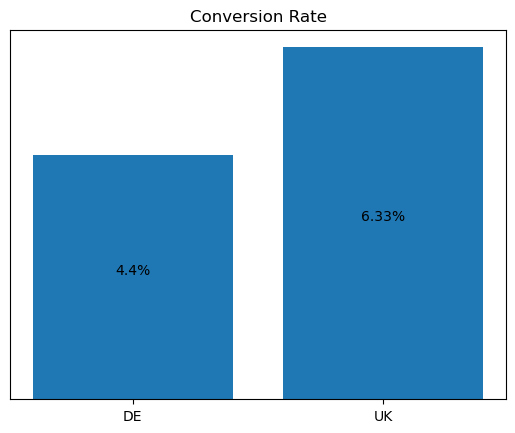

conversion_rate
Country Code Campaign Name                 
DE           Run                       4.15
             Women                     7.08
UK           Run                       6.66
             Women                     4.52

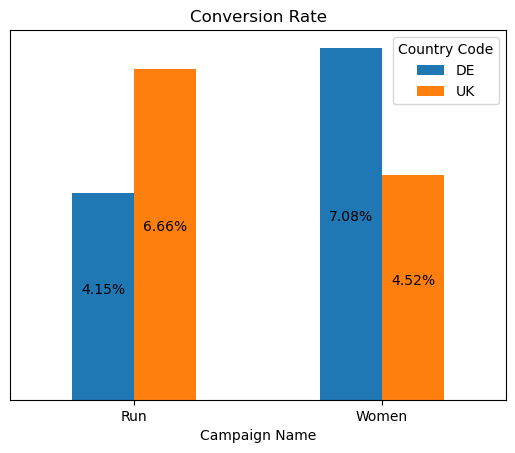

conversion_rate
Country Code Channel                 
DE           FB                  3.95
             IG                  7.90
UK           FB                  6.62
             IG                  5.22

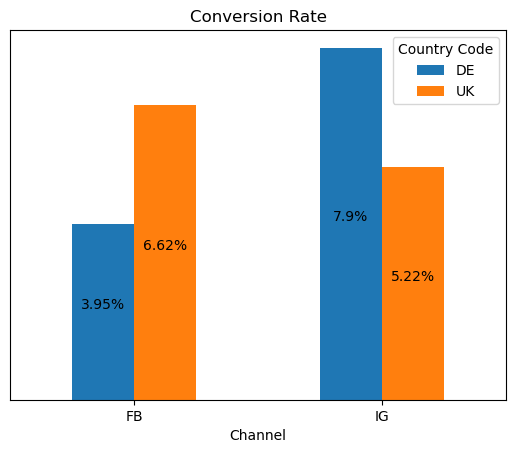

conversion_rate
Country Code Tactic                        
DE           Awareness                 0.44
             Consideration            22.58
             Conversion               14.15
UK           Awareness                 0.59
             Consideration            21.02
             Conversion               22.04

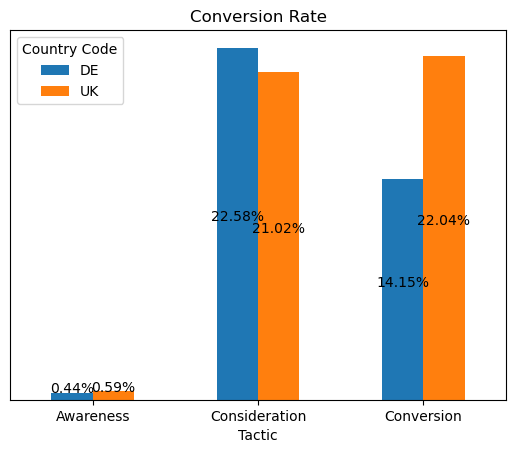

In [26]:
# Conversion rate analysis by countries and other metrics
rate_cal(data, "CVR", "Country Code")
rate_cal(data, "CVR", ["Country Code","Campaign Name"])
rate_cal(data, "CVR", ["Country Code","Channel"]) 
rate_cal(data, "CVR", ["Country Code","Tactic"])

* Contrary to the daily figures, the *UK* boasts a higher overall conversion rate of 6.33%, surpassing the 4.4% rate observed in *DE*
* Upon closer examination, the performance of conversion rates in both countries exhibits variations across campaigns, channels, and tactic types
* Average ads conversion rates across all industries from research: FB 9.11%<sup>6</sup>, IG between 0.7% and 1.3%<sup>7</sup>
* Therefore, both countries had outstanding performance on IG but below average on FB

<sup>6. Source: WordStream, https://www.wordstream.com/blog/ws/2019/11/12/facebook-ad-benchmarks</sup><br>
<sup>7. Source: Bazaarvoice, https://www.bazaarvoice.com/blog/key-instagram-metrics/</sup>

### 3. During which period of the year do we observe the most conversions? 

#### 3a. Top 5 daily conversion number records

In [27]:
# Show the top 5 daily conversion number records
data.sort_values(by="Conversions", ascending=False).head()

Date  Media Cost  Impressions  Conversions  Clicks Channel  \
31 2022-02-01      234.05        84920         2842    4063      FB   
30 2022-01-31      234.03        84368         2780    4301      FB   
19 2022-01-20      268.59        78573         2635    3980      FB   
18 2022-01-19      268.38        77157         2583    3621      FB   
22 2022-01-23      589.63       101415         2367   10334      FB   

   Country Code         Tactic Campaign Name   Week Day  click_through_rate  \
31           UK  Consideration           Run    Tuesday            4.784503   
30           UK  Consideration           Run     Monday            5.097904   
19           UK  Consideration           Run   Thursday            5.065353   
18           UK  Consideration           Run  Wednesday            4.693029   
22           UK     Conversion           Run     Sunday           10.189814   

    conversion_rate Campaign Code PO Number  
31        69.948314          FW20  PO965182  
30        64.636131          FW20  PO311742  
19        66.206030          FW20  PO738355  
18        71.333886          FW20  PO752478  
22        22.904974          FW20  PO983862

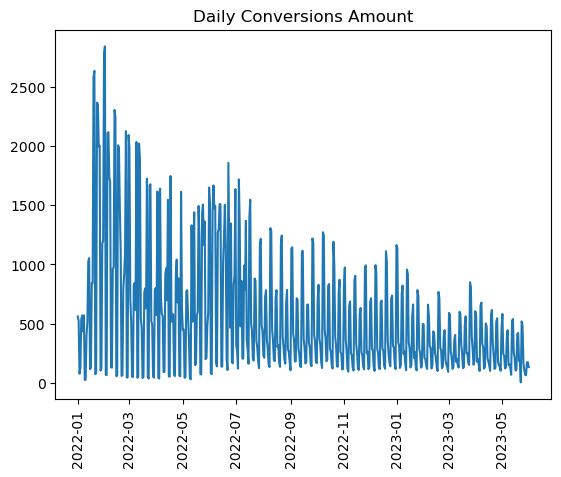

In [28]:
# Plot the data
plt.plot(data['Date'], data['Conversions'])
plt.title('Daily Conversions Amount')
plt.xticks(rotation=90)
plt.show()

* In terms of the daily number of conversions, the highest value is observed on 1st February 2022 with 2842
* The amount was fluctuated but high values and hence the amplitudes kept decreasing over time

#### 3b. Average monthly number of conversions

In [29]:
# Extract the year and month from the 'Date' column
data2 = data.copy()
data2['Year_Month'] = data2['Date'].dt.to_period('M')

# Group by Year_Month and take average of the 'Conversions'
data_monthly_conversions = data2.groupby('Year_Month')['Conversions'].mean().reset_index()
data_monthly_conversions.sort_values(by="Conversions", ascending=False).round(2)

Year_Month  Conversions
1     2022-02      1118.93
5     2022-06       921.50
0     2022-01       897.74
2     2022-03       733.35
4     2022-05       671.97
3     2022-04       652.77
6     2022-07       634.94
8     2022-09       485.20
7     2022-08       474.81
9     2022-10       464.42
11    2022-12       438.68
12    2023-01       401.23
10    2022-11       397.77
14    2023-03       336.87
15    2023-04       302.23
13    2023-02       286.61
16    2023-05       239.39

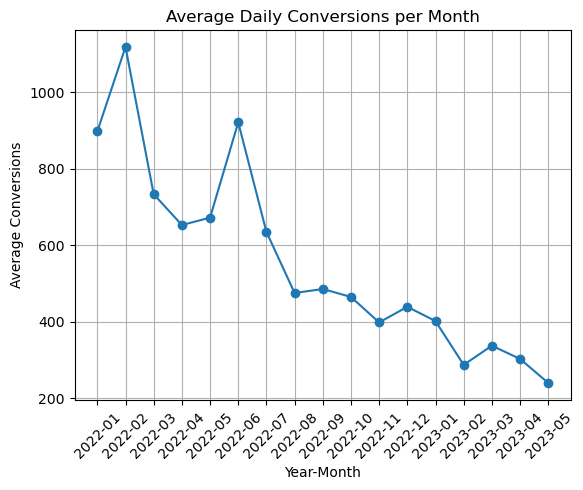

In [30]:
# Plot the data
plt.plot(data_monthly_conversions['Year_Month'].astype(str), data_monthly_conversions['Conversions'], marker='o')
plt.title('Average Daily Conversions per Month')
plt.xlabel('Year-Month')
plt.ylabel('Average Conversions')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

* While when looking into the average daily number of coversion per month, 2 peaks are observed at February and June 2022, with around 1119 and 922 conversions

In [31]:
# Extract the year and quarter from the 'Date' column
data2 = data.copy()
data2['Year_Quarter'] = data2['Date'].dt.to_period('Q')

# Group by Year_Quarter and take average of the 'Conversions'
data_quarterly_conversions = data2.groupby('Year_Quarter')['Conversions'].mean().reset_index()
data_quarterly_conversions.sort_values(by="Conversions", ascending=False).round(2)

Year_Quarter  Conversions
0       2022Q1       909.93
1       2022Q2       747.90
2       2022Q3       532.15
3       2022Q4       434.01
4       2023Q1       343.40
5       2023Q2       270.30

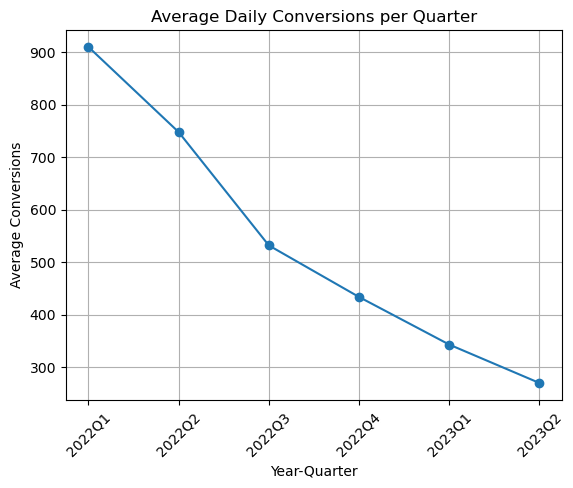

In [32]:
# Plot the data
plt.plot(data_quarterly_conversions['Year_Quarter'].astype(str), data_quarterly_conversions['Conversions'], marker='o')
plt.title('Average Daily Conversions per Quarter')
plt.xlabel('Year-Quarter')
plt.ylabel('Average Conversions')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

* In terms of the quarterly performance, the average daily conversions dropped significantly from around 900 at the beginning at quarter 1 2022 to less than 300 at quarter 2 2023

### 4. What percentage change in conversions is observed month over month (MoM)? 

In [33]:
# Calculate the total amount of conversions in each month
conversion_mom_change = data[['Date', 'Conversions']].resample('M', on='Date').sum()

# Calculate the Month-over-Month percentage changes in conversions and display it
conversion_mom_change['percentage_change'] = conversion_mom_change['Conversions'].pct_change() * 100
conversion_mom_change.reset_index(inplace=True)
conversion_mom_change

Date  Conversions  percentage_change
0  2022-01-31        27830                NaN
1  2022-02-28        31330          12.576356
2  2022-03-31        22734         -27.436961
3  2022-04-30        19583         -13.860297
4  2022-05-31        20831           6.372874
5  2022-06-30        27645          32.710864
6  2022-07-31        19683         -28.800868
7  2022-08-31        14719         -25.219733
8  2022-09-30        14556          -1.107412
9  2022-10-31        14397          -1.092333
10 2022-11-30        11933         -17.114677
11 2022-12-31        13599          13.961284
12 2023-01-31        12438          -8.537392
13 2023-02-28         8025         -35.479981
14 2023-03-31        10443          30.130841
15 2023-04-30         9067         -13.176290
16 2023-05-31         7421         -18.153744

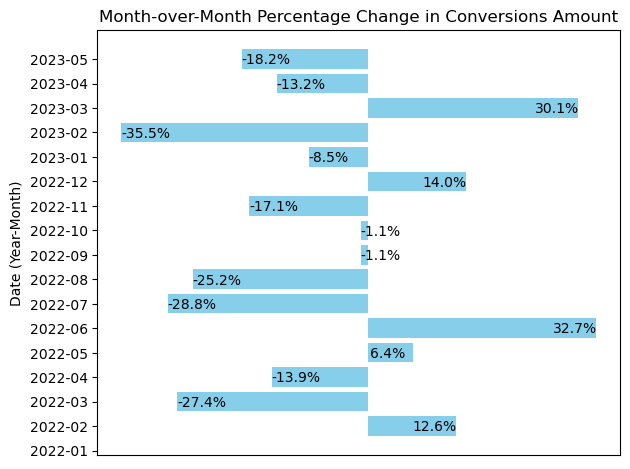

In [34]:
# Plot bar chart to show the MoM% changes
bars = plt.barh(conversion_mom_change['Date'].dt.strftime('%Y-%m'), conversion_mom_change['percentage_change'], color='skyblue')
plt.ylabel('Date (Year-Month)')
plt.xlabel('Percentage Change')
plt.title('Month-over-Month Percentage Change in Conversions Amount')

# Show the values in the bars
for bar, label in zip(bars, conversion_mom_change['percentage_change']):
    if bar.get_width() >= -100:
        if bar.get_width() < 0:
            plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 4, f'{label:.1f}%')
        else:
            plt.text(bar.get_width()-6.2, bar.get_y() + bar.get_height() / 4, f'{label:.1f}%')

# Other plot customisation
plt.xticks([])
plt.xlabel('')
plt.tight_layout()
plt.show()

* The Month-over-Month changes were fluctuated
* Negative growths are observed in 11 out of 16 months, which mean nearly 70% of the months were not performing well

### 5. Create an overall visual representation to show how the marketing funnel (Tactic) performs in terms of conversions.

* It is observed in the `Tactic`, there is a 6-day cycle with the order as *"consideration > awareness > conversion"* and each of them last for 2 days
* The cycle started with 6 days in `DE`, followed by another 6 days in the `UK`, then back to `DE` for 6 days again an so on
* It is different from what is normally expected with the sequence as *"awareness > consideration > conversion"*. This could possibly be the special marketing strategy implemented by the company.

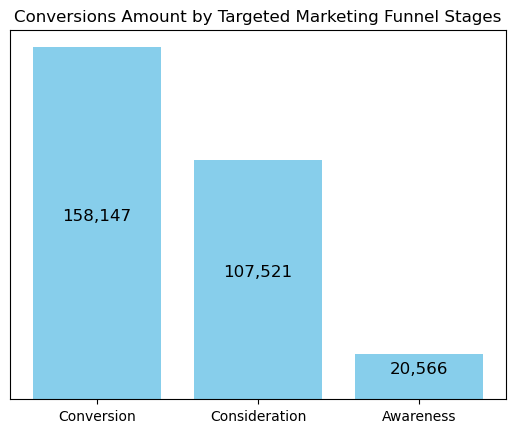

In [35]:
# Calculate the total amount of conversions in each Targeted Marketing Funnel Stages (tactic types) and plot the result
conversion_by_tactic = data.groupby('Tactic')['Conversions'].sum().reset_index()
conversion_by_tactic = conversion_by_tactic.sort_values(by='Conversions', ascending=False)

# Label the bars
bars = plt.bar(conversion_by_tactic['Tactic'], conversion_by_tactic['Conversions'], color='skyblue')
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2, f'{bar.get_height():,}', 
             va='bottom', ha='center', size="large")

# Other plot customisation
plt.yticks([])
plt.title('Conversions Amount by Targeted Marketing Funnel Stages')
plt.show()

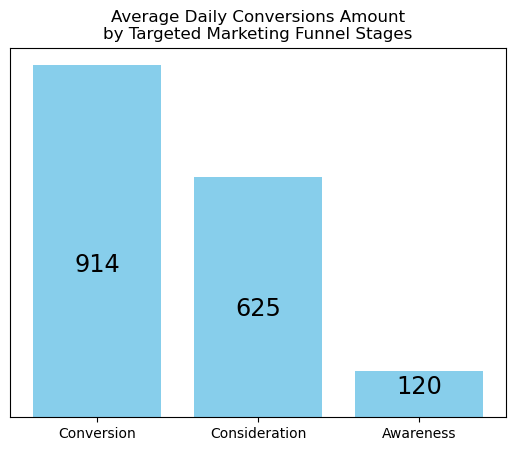

In [36]:
# Calculate the average daily amount of conversions in each Targeted Marketing Funnel Stages (tactic types) and plot the result
avg_conversion_by_tactic = data.groupby('Tactic')['Conversions'].mean().reset_index()
avg_conversion_by_tactic = avg_conversion_by_tactic.sort_values(by='Conversions', ascending=False)

# Label the bars
bars = plt.bar(avg_conversion_by_tactic['Tactic'], avg_conversion_by_tactic['Conversions'], color='skyblue')
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2.5, f'{bar.get_height():.0f}', 
             va='bottom', ha='center', size="xx-large")

# Other plot customisation
plt.yticks([])
plt.title('Average Daily Conversions Amount\nby Targeted Marketing Funnel Stages')
plt.show()

* For the number of conversions, during the days where the marketing objectives were the conversion stage, it had an amount exceed nearly 50% of that of the consideration stage and over 660% more than that of the awareness stage

conversion_rate
Tactic                        
Awareness                 0.51
Consideration            21.67
Conversion               17.21

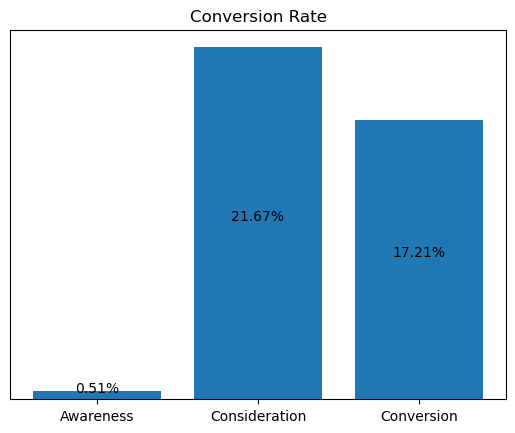

In [37]:
# Show the conversion rates in each targeted marketing funnel stages (tactic types)
rate_cal(data, "CVR", "Tactic")

* While for the conversion rate, both values in the consideration and conversion stages had got excellent results with 17 – nearly 22%
* It is interesting that although the main focus in the consideration stage is to generate higher number of clicks and click-through rate, during these days it had even better performance than those days which have the conversion stage as the objective

In [38]:
# Plot the marketing funnel
import plotly.graph_objects as go

total_impressions = data['Impressions'].sum()
total_clicks = data['Clicks'].sum()
total_conversions = data['Conversions'].sum()

fig = go.Figure()
fig.add_trace(go.Funnel(
    name='rketing Funnel Performance',
    y=['Awareness<br>(No. of impressions)', 'Consideration<br>(No. of clicks)', 'Conversion<br>(No. of conversions)'],
    x=[total_impressions, total_clicks, total_conversions],
    textinfo="value+percent initial",texttemplate = "%{value}<br>%{percentInitial:,.2%}",
    hoverinfo="percent previous"))
fig.update_layout(title_text="Marketing Funnel Performance")
fig.show()

* The performance of the awareness, consideration and conversion funnel stages are represented by total amount of impressions, clicks and conversions respectively
* The overall click-through rate (% of impressions went into the consideration stage) is 9.95%
* The overall conversion rate (% of clicks went into the conversion stage) is 5.2%
* 0.52% of the impressions went through the consideration stage and further went into the covnersion stage
* Comparing to the research average, the company was performing outstandingly in terms of the average click-through rate but have various conversion rate performance depending on the channel used



## 6. Additional analysis on Media Cost

### 6a. Plotting individual data points

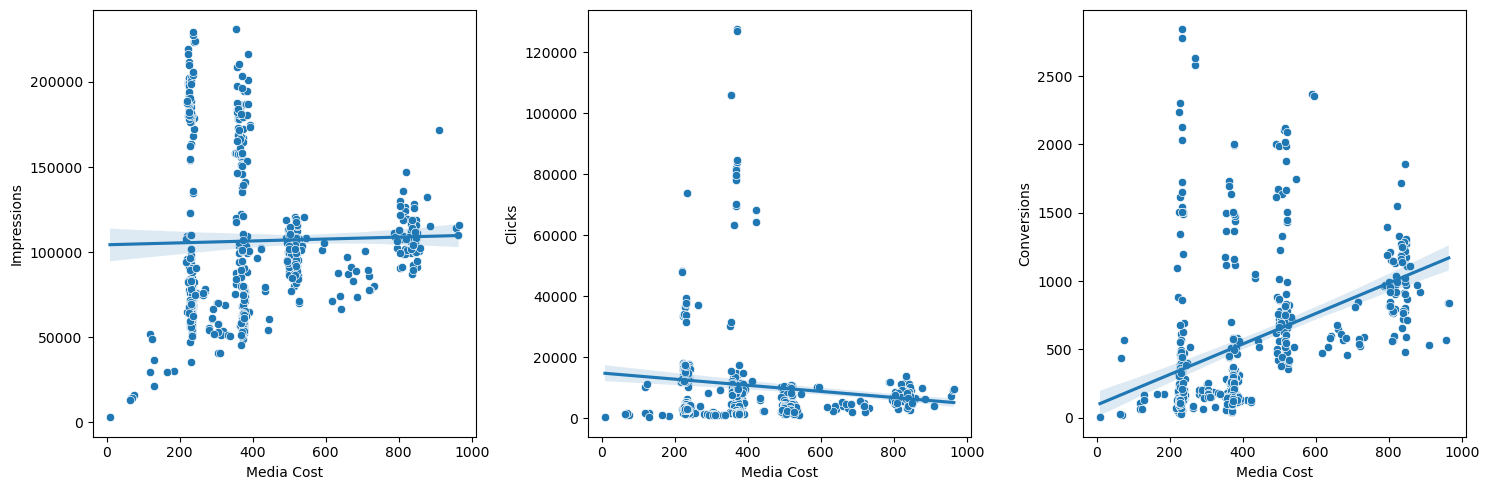

In [39]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first jointplot
sns.scatterplot(data=data, y="Impressions", x="Media Cost", ax=axes[0])
sns.regplot(data=data, y="Impressions", x="Media Cost", scatter=False, ax=axes[0])

# Plot the second jointplot
sns.scatterplot(data=data, y="Clicks", x="Media Cost", ax=axes[1])
sns.regplot(data=data, y="Clicks", x="Media Cost", scatter=False, ax=axes[1])

# Plot the third jointplot
sns.scatterplot(data=data, y="Conversions", x="Media Cost", ax=axes[2])
sns.regplot(data=data, y="Conversions", x="Media Cost", scatter=False, ax=axes[2])

# Display the plots
plt.tight_layout()
plt.show()

* There are correlations observed where Higher *Media Cost* associated with more number of *Impressions* and *Conversions*
* When daily *Media Cost* spending were between 200 - 400, some high values of *Impressions*. *Click*, and *Conversions* could be observed

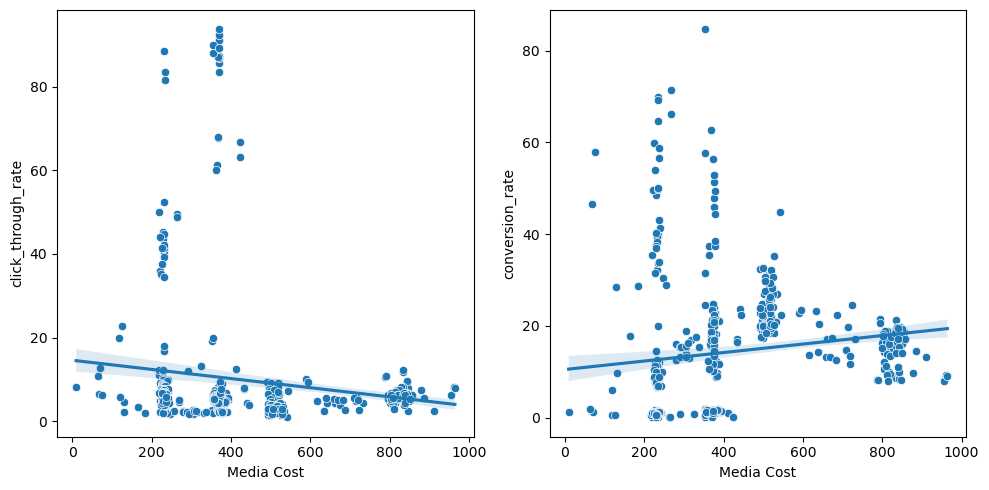

In [40]:
# Examine relationship between CTR/CVR and the Media Cost
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first jointplot
sns.scatterplot(data=data, y="click_through_rate", x="Media Cost", ax=axes[0])
sns.regplot(data=data, y="click_through_rate", x="Media Cost", scatter=False, ax=axes[0])

# Plot the second jointplot
sns.scatterplot(data=data, y="conversion_rate", x="Media Cost", ax=axes[1])
sns.regplot(data=data, y="conversion_rate", x="Media Cost", scatter=False, ax=axes[1])


# Display the plots
plt.tight_layout()
plt.show()

* In terms of the *click-through rate* and *conversion rate*, there is no strong overall correlation observed with the *Media Cost*
* But there are some high *click-through rate* and *conversion rate* are observed with *Media Cost* between $200 - $400

### 6b. Plotting average values by Media Cost in intervals of $50

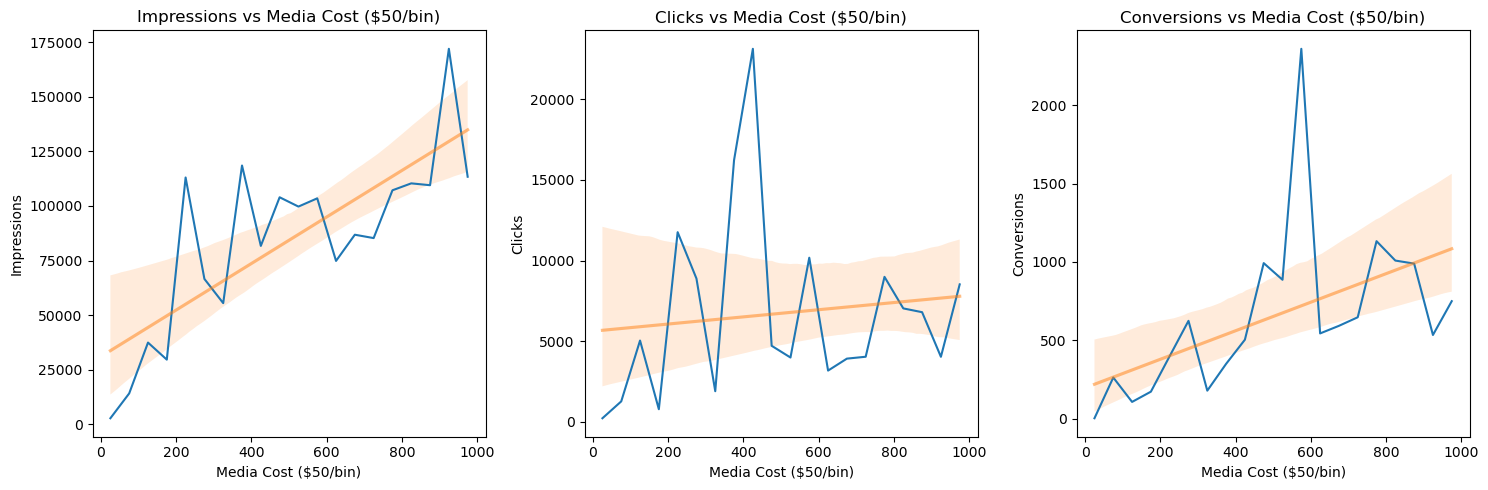

In [41]:
# Visualise the average number of Impressions/Clicks/Conversions by Media Cost in intervals of $50
bins = pd.cut(data['Media Cost'], bins=range(0, int(data['Media Cost'].max()) + 51, 50))

# Assign bin labels to a new column 'Media Cost($50/bin)'
data['Media Cost ($50/bin)'] = bins

# Group by the bins and calculate mean for 'Impressions', 'Clicks', and 'Conversions'
grouped_data = data.groupby('Media Cost ($50/bin)')[['Impressions', 'Clicks', 'Conversions']].mean()

# Reset index for 'Media Cost($50/bin)'
grouped_data.reset_index(inplace=True)

# Get the midpoints of the intervals for x values
midpoints = grouped_data['Media Cost ($50/bin)'].apply(lambda x: x.mid)

# Create a figure and axis for subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Loop through each subplot and plot line chart with regression line
for i, column in enumerate(['Impressions', 'Clicks', 'Conversions']):
    sns.lineplot(data=grouped_data, x=midpoints, y=column, ax=axes[i])
    sns.regplot(data=grouped_data, x=midpoints, y=column, ax=axes[i], scatter=False, line_kws={'alpha':0.5})

    # Set plot title
    axes[i].set_title(f'{column} vs Media Cost ($50/bin)')

# Display the plots
plt.tight_layout()
plt.show()


* *Media Cost* show correlations with all the numbers of *Impressions, Clicks, Conversions*
* Outstanding performances observed in:<br>
&nbsp;&nbsp;&nbsp;&nbsp;-*Impression* when the *Media Cost* were $150-$200, $300-$350, and $850-$900<br>
&nbsp;&nbsp;&nbsp;&nbsp;-*Clicks* when the *Media Cost* were $150-$250, and $300-$450<br>
&nbsp;&nbsp;&nbsp;&nbsp;-*Conversions* when the *Media Cost* were $400-$550, and $700-$850

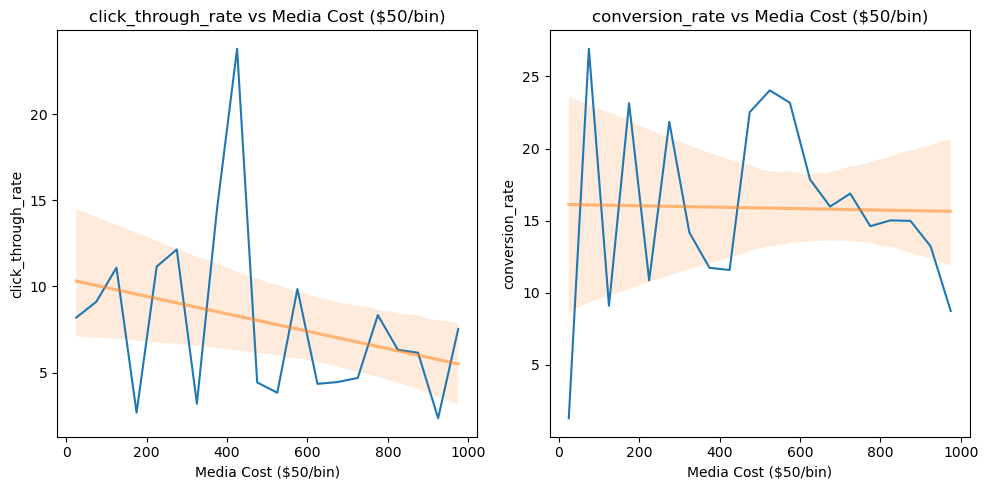

In [42]:
# Visualise the average CTR and CVR by Media Cost in intervals of $50
bins = pd.cut(data['Media Cost'], bins=range(0, int(data['Media Cost'].max()) + 51, 50))

# Assign bin labels to a new column 'Media Cost($50/bin)'
data['Media Cost ($50/bin)'] = bins

# Group by the bins and calculate mean for CTR and CVR
grouped_data = data.groupby('Media Cost ($50/bin)')[['click_through_rate', 'conversion_rate']].mean()

# Reset index for 'Media Cost($50/bin)'
grouped_data.reset_index(inplace=True)

# Get the midpoints of the intervals for x values
midpoints = grouped_data['Media Cost ($50/bin)'].apply(lambda x: x.mid)

# Create a figure and axis for subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Loop through each subplot and plot line chart with regression line
for i, column in enumerate(['click_through_rate', 'conversion_rate']):
    sns.lineplot(data=grouped_data, x=midpoints, y=column, ax=axes[i])
    sns.regplot(data=grouped_data, x=midpoints, y=column, ax=axes[i], scatter=False, line_kws={'alpha':0.5})

    # Set plot title
    axes[i].set_title(f'{column} vs Media Cost ($50/bin)')

# Display the plots
plt.tight_layout()
plt.show()

* *Media Cost* doesn't show correlations with both *CTR* and *CVR*
* Outstanding performances observed in:<br>
&nbsp;&nbsp;&nbsp;&nbsp;-*CTR* when the *Media Cost* were $50-$100, $200-$250, and $300-$400<br>
&nbsp;&nbsp;&nbsp;&nbsp;-*CVR* when the *Media Cost* were $0-$50, $100-$150, and $400-$550

### 6c. Analysis of *Media Cost* by *Campaigns*

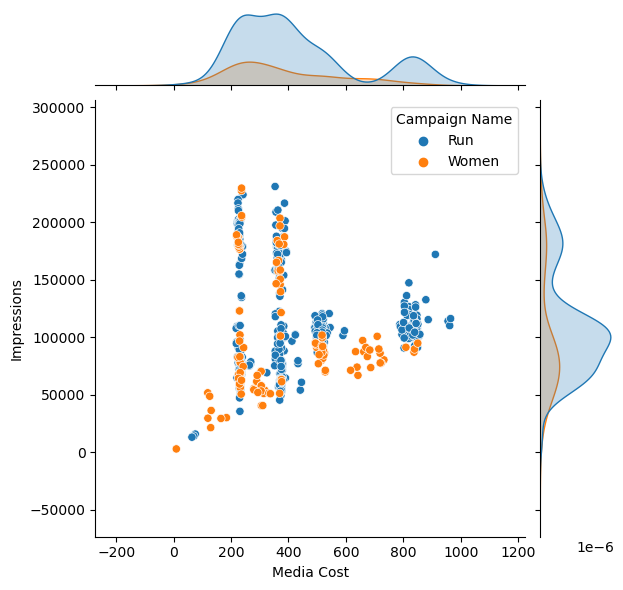

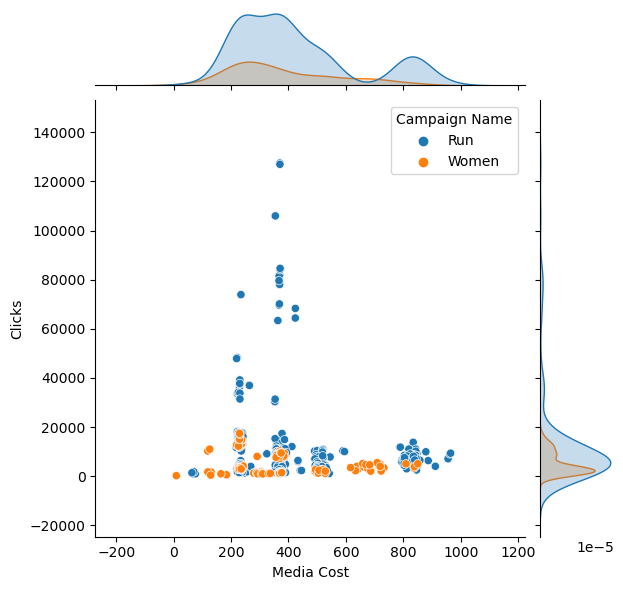

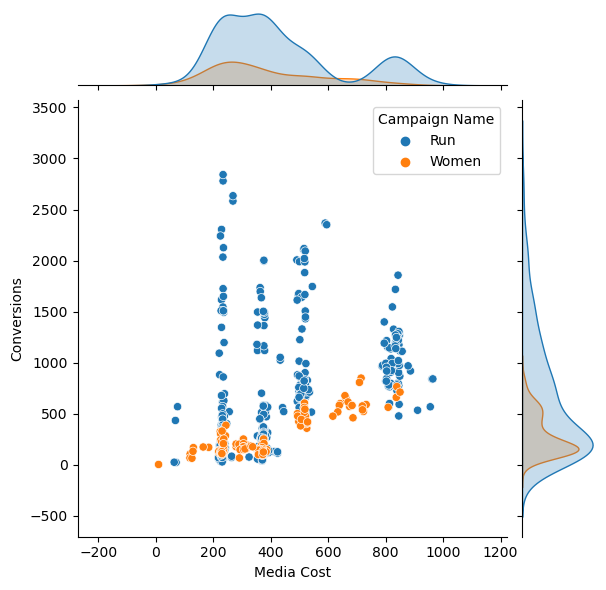

In [43]:
# Examine relationship between number of Impressions/Clicks/Conversions and the Media Cost by campaigns
sns.jointplot(data, y="Impressions", x="Media Cost", hue='Campaign Name')
sns.jointplot(data, y="Clicks", x="Media Cost", hue='Campaign Name')
sns.jointplot(data, y="Conversions", x="Media Cost", hue='Campaign Name')

* The *Run* campaign generated more high numbers of *Clicks* and *Conversions* than the *Women* campaign
* Both campaign show certain levels of correlation between the *Media Cost* and the *Impressions/Clicks/Conversions* amount

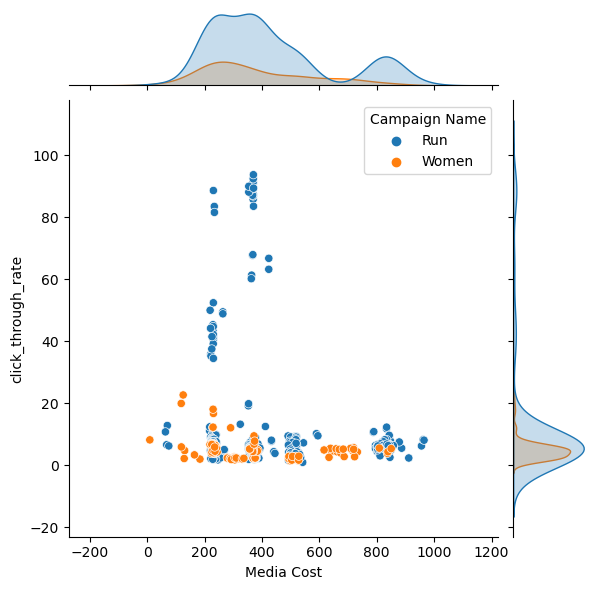

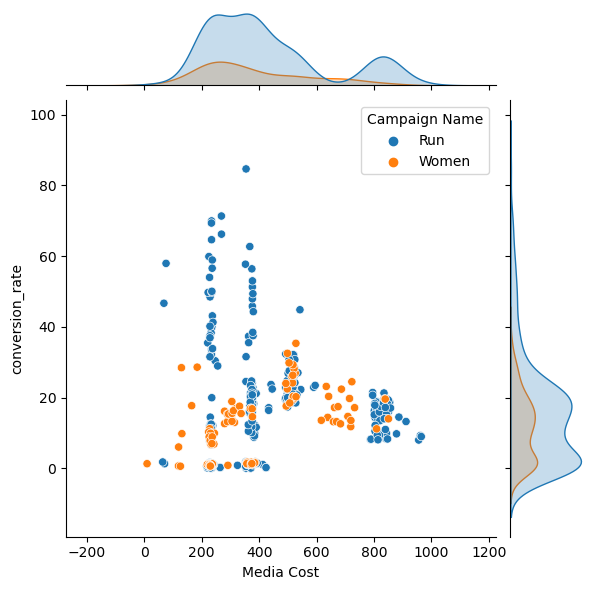

In [44]:
# Examine relationship between CTR/CVR and the Media Cost by campaigns
sns.jointplot(data, y="click_through_rate", x="Media Cost", hue='Campaign Name')
sns.jointplot(data, y="conversion_rate", x="Media Cost", hue='Campaign Name')

* Similarly, the *Run* campaign also has higher numbers of *Clicks* and *Conversions* than the *Women* campaign with *Media Cost* between 200 - 400

### 6d. Analysis of *Media Cost* by *Country*

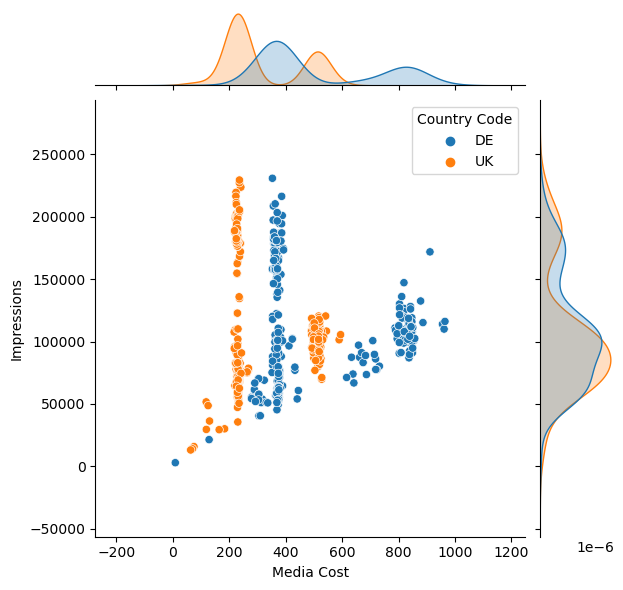

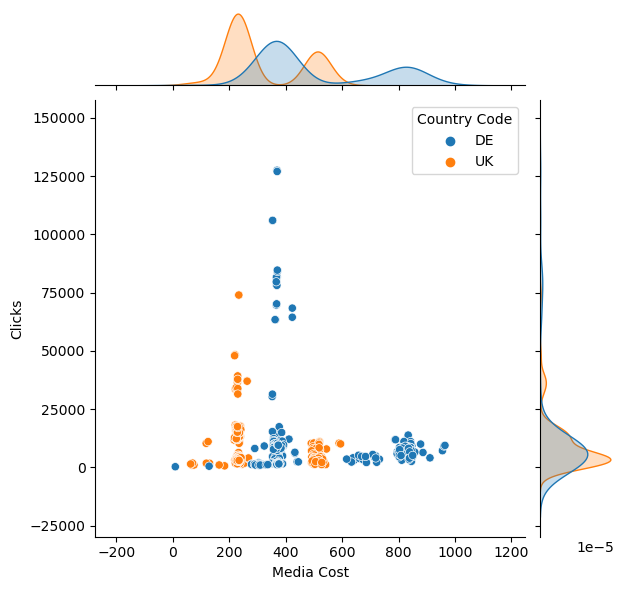

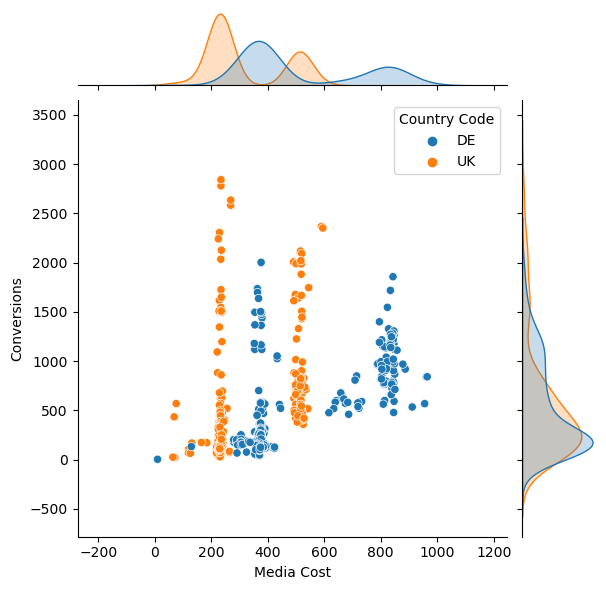

In [45]:
# Examine relationship between number of Impressions/Clicks/Conversions and the Media Cost by countries
sns.jointplot(data, y="Impressions", x="Media Cost", hue='Country Code')
sns.jointplot(data, y="Clicks", x="Media Cost", hue='Country Code')
sns.jointplot(data, y="Conversions", x="Media Cost", hue='Country Code')

* We can observe a clear difference of the *Media Cost* expenses in the two countries
* Higher *Media Cost* could be related to higher number of *Impressions* and *Conversions* in both countries
* Some particularly high values of *Impressions/Clicks/Conversions* are observed in some *Media Cost* such as around $200, $400, $500, and $800

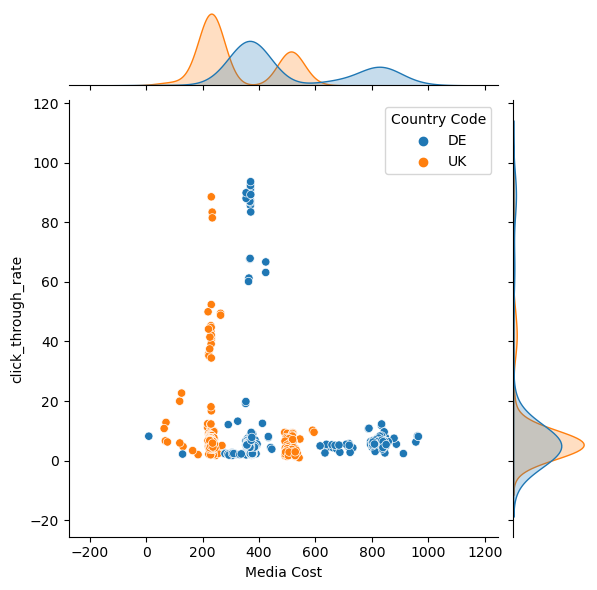

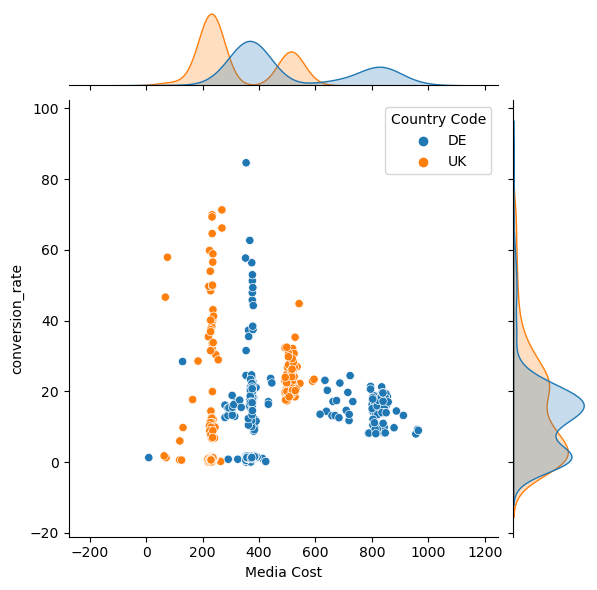

In [46]:
# Examine relationship between CTR/CVR and the Media Cost
sns.jointplot(data, y="click_through_rate", x="Media Cost", hue='Country Code')
sns.jointplot(data, y="conversion_rate", x="Media Cost", hue='Country Code')

* While for both the *click-through rate* and *conversion rate*, there is not observable correlation to the *Media Cost* in both countries
* Some strong performance observed when the *Media Cost* were around $200, $400, and $500